<a href="https://colab.research.google.com/github/Falconly/Neuron-Network/blob/main/dogs_cats_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm.autonotebook import tqdm

plt.style.use('dark_background')
warnings.filterwarnings('ignore', 'FutureWarning')

import zipfile
from google.colab import drive

<ipython-input-1-1aae65d74c83>:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Create Dataset

In [2]:
class Dataset2Class(Dataset):
    def __init__(self, path_dir1: str, path_dir2: str):
        super().__init__()

        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2

        # Получение списков, содержащих имена файлов и директорий в
        # каталогах path_dir1, path_dir2
        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))

        self.len_dir1_list = len(self.dir1_list)

    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)

    def __getitem__(self, idx):
        if idx < self.len_dir1_list:
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= self.len_dir1_list
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img / 255.0
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA) # for vgg16
        # img = cv2.resize(img, (50, 50), interpolation=cv2.INTER_AREA) # for cnn
        img = img.transpose((2, 0, 1))
        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)

        return {'img': t_img, 'label': t_class_id}

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_file = '/content/drive/My Drive/Google Collab/dogscats.zip'

# Распаковка архива
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

print(os.listdir())

['.config', 'dogscats', 'drive', 'sample_data']


In [5]:
zip_directory = '/content/dogscats'

In [6]:
# 0 - dogs, 1 - cats

# train_dogs_path = '/kaggle/input/dog-vs-cat-fastai/dogscats/train/dogs'
# train_cats_path = '/kaggle/input/dog-vs-cat-fastai/dogscats/train/cats'

# test_dogs_path = '/kaggle/input/dog-vs-cat-fastai/dogscats/valid/dogs'
# test_cats_path = '/kaggle/input/dog-vs-cat-fastai/dogscats/valid/cats'

train_dogs_path = zip_directory + '/train/dogs'
train_cats_path = zip_directory + '/train/cats'

test_dogs_path = zip_directory + '/valid/dogs'
test_cats_path = zip_directory + '/valid/cats'

train_dataset = Dataset2Class(train_dogs_path, train_cats_path)
test_dataset = Dataset2Class(test_dogs_path, test_cats_path)

In [7]:
train_dataset[0]['img']

tensor([[[0.4586, 0.4523, 0.4180,  ..., 0.5205, 0.5199, 0.5169],
         [0.4640, 0.4578, 0.4239,  ..., 0.5250, 0.5256, 0.5287],
         [0.4721, 0.4658, 0.4311,  ..., 0.5328, 0.5287, 0.5333],
         ...,
         [0.2713, 0.2850, 0.2741,  ..., 0.2463, 0.2806, 0.2973],
         [0.2737, 0.2815, 0.2848,  ..., 0.2943, 0.2958, 0.2803],
         [0.2593, 0.2560, 0.2644,  ..., 0.3139, 0.2531, 0.2533]],

        [[0.4507, 0.4445, 0.4089,  ..., 0.5284, 0.5268, 0.5169],
         [0.4562, 0.4499, 0.4149,  ..., 0.5329, 0.5325, 0.5287],
         [0.4643, 0.4580, 0.4220,  ..., 0.5407, 0.5356, 0.5333],
         ...,
         [0.2909, 0.3070, 0.3079,  ..., 0.2816, 0.3173, 0.3365],
         [0.2933, 0.3035, 0.3186,  ..., 0.3296, 0.3325, 0.3196],
         [0.2789, 0.2780, 0.2982,  ..., 0.3492, 0.2898, 0.2925]],

        [[0.4947, 0.4963, 0.4675,  ..., 0.5754, 0.5659, 0.5491],
         [0.5001, 0.5017, 0.4734,  ..., 0.5799, 0.5716, 0.5609],
         [0.5082, 0.5098, 0.4805,  ..., 0.5877, 0.5746, 0.

## Create Dataloader

In [8]:
batch_size = 4
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          drop_last=True,
                          batch_size=batch_size,
                         )
test_loader = DataLoader(test_dataset,
                        shuffle=True,
                        batch_size=batch_size,
                        )

## Architecture CNN

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1)

        self.maxpool = nn.MaxPool2d(2, 2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1)) # Автоматически рассчитывает значения
                                                        # для достижения указанного рамера
        self.leaky_relu = nn.LeakyReLU(0.2)

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64, 10)
        self.linear2 = nn.Linear(10, 2)

    def forward(self, x):
        # Сверточная сеть
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.adaptivepool(x)

        # Полносвязная сеть
        x = self.flatten(x)

        x = self.linear1(x)
        x = self.leaky_relu(x)

        x = self.linear2(x)

        return x

In [10]:
model = ConvNet()

In [11]:
print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)


In [12]:
for sample in train_loader:
    img = sample['img']
    print(img.shape)
    model(img)
    break

torch.Size([4, 3, 224, 224])


## Learn CNN

In [ ]:
def accuracy(pred: torch.Tensor, target: torch.Tensor) -> int:
  answer = F.softmax(pred.detach()).cpu().numpy().argmax(1) == target.cpu().numpy().argmax(1)
  return answer.mean()

In [ ]:
def train(model, optimizer, loss_function):
  for iteration, tensor in enumerate(train_loader):

        X_batch = tensor.get('img').to(DEVICE)
        y_batch = tensor.get('label').to(DEVICE)
        y_batch = F.one_hot(y_batch, 2).to(torch.float32)

        model.train()
        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = loss_function(outputs, y_batch)

        loss.backward()

        acc = accuracy(outputs, y_batch)

        acc_train.append(acc)
        train_loss.append(loss.detach().cpu().numpy().item())

        optimizer.step()

        current = (iteration + 1) * len(X_batch)
        if current % 1000 == 0:
            print(f'loss: {loss:>7f} [{current}|{size:>2d}] Accuracy: {np.mean(acc_train)}')

In [ ]:
def validation(model, loss_function):
  for iteration, tensor in enumerate(test_loader):
        X_val = tensor.get('img').to(DEVICE)
        y_val = tensor.get('label').to(DEVICE)
        y_val = F.one_hot(y_val, 2).to(torch.float32)
        with torch.no_grad():
            model.eval()

            outputs = model(X_val)

            loss = loss_function(outputs, y_val)
            acc = accuracy(outputs, y_val)

            acc_val.append(acc)
            val_loss.append(loss.detach().cpu().numpy().item())

In [ ]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

model = model.to(DEVICE)
EPOCHS = 15
# accuracy = torchmetrics.Accuracy(task='binary').to(DEVICE)

In [ ]:
train_loss = []
total_loss = []

val_loss = []
total_val_loss = []

acc_train = []
acc_val = []

size = len(train_dataset)

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    print(f'Epochs {epoch+1} \n------------------------')
    train()
    total_loss.append(np.mean(train_loss)) # для графика

    validation()
    total_val_loss.append(np.mean(val_loss)) # для графика
    print(f'Validation Error:\nAccuracy: {np.mean(acc_val)} Avg Loss: {np.mean(val_loss)}')

  0%|          | 0/15 [00:00<?, ?it/s]

Epochs 1 
------------------------


<ipython-input-38-181d0426d01e>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).cpu().numpy().argmax(1) == target.cpu().numpy().argmax(1)


loss: 0.517208 [2000|23000] Accuracy: 0.6755
loss: 0.642347 [4000|23000] Accuracy: 0.68625
loss: 0.588152 [6000|23000] Accuracy: 0.6888333333333333
loss: 0.500658 [8000|23000] Accuracy: 0.690875
loss: 0.614221 [10000|23000] Accuracy: 0.692
loss: 0.496888 [12000|23000] Accuracy: 0.69325


KeyboardInterrupt: 

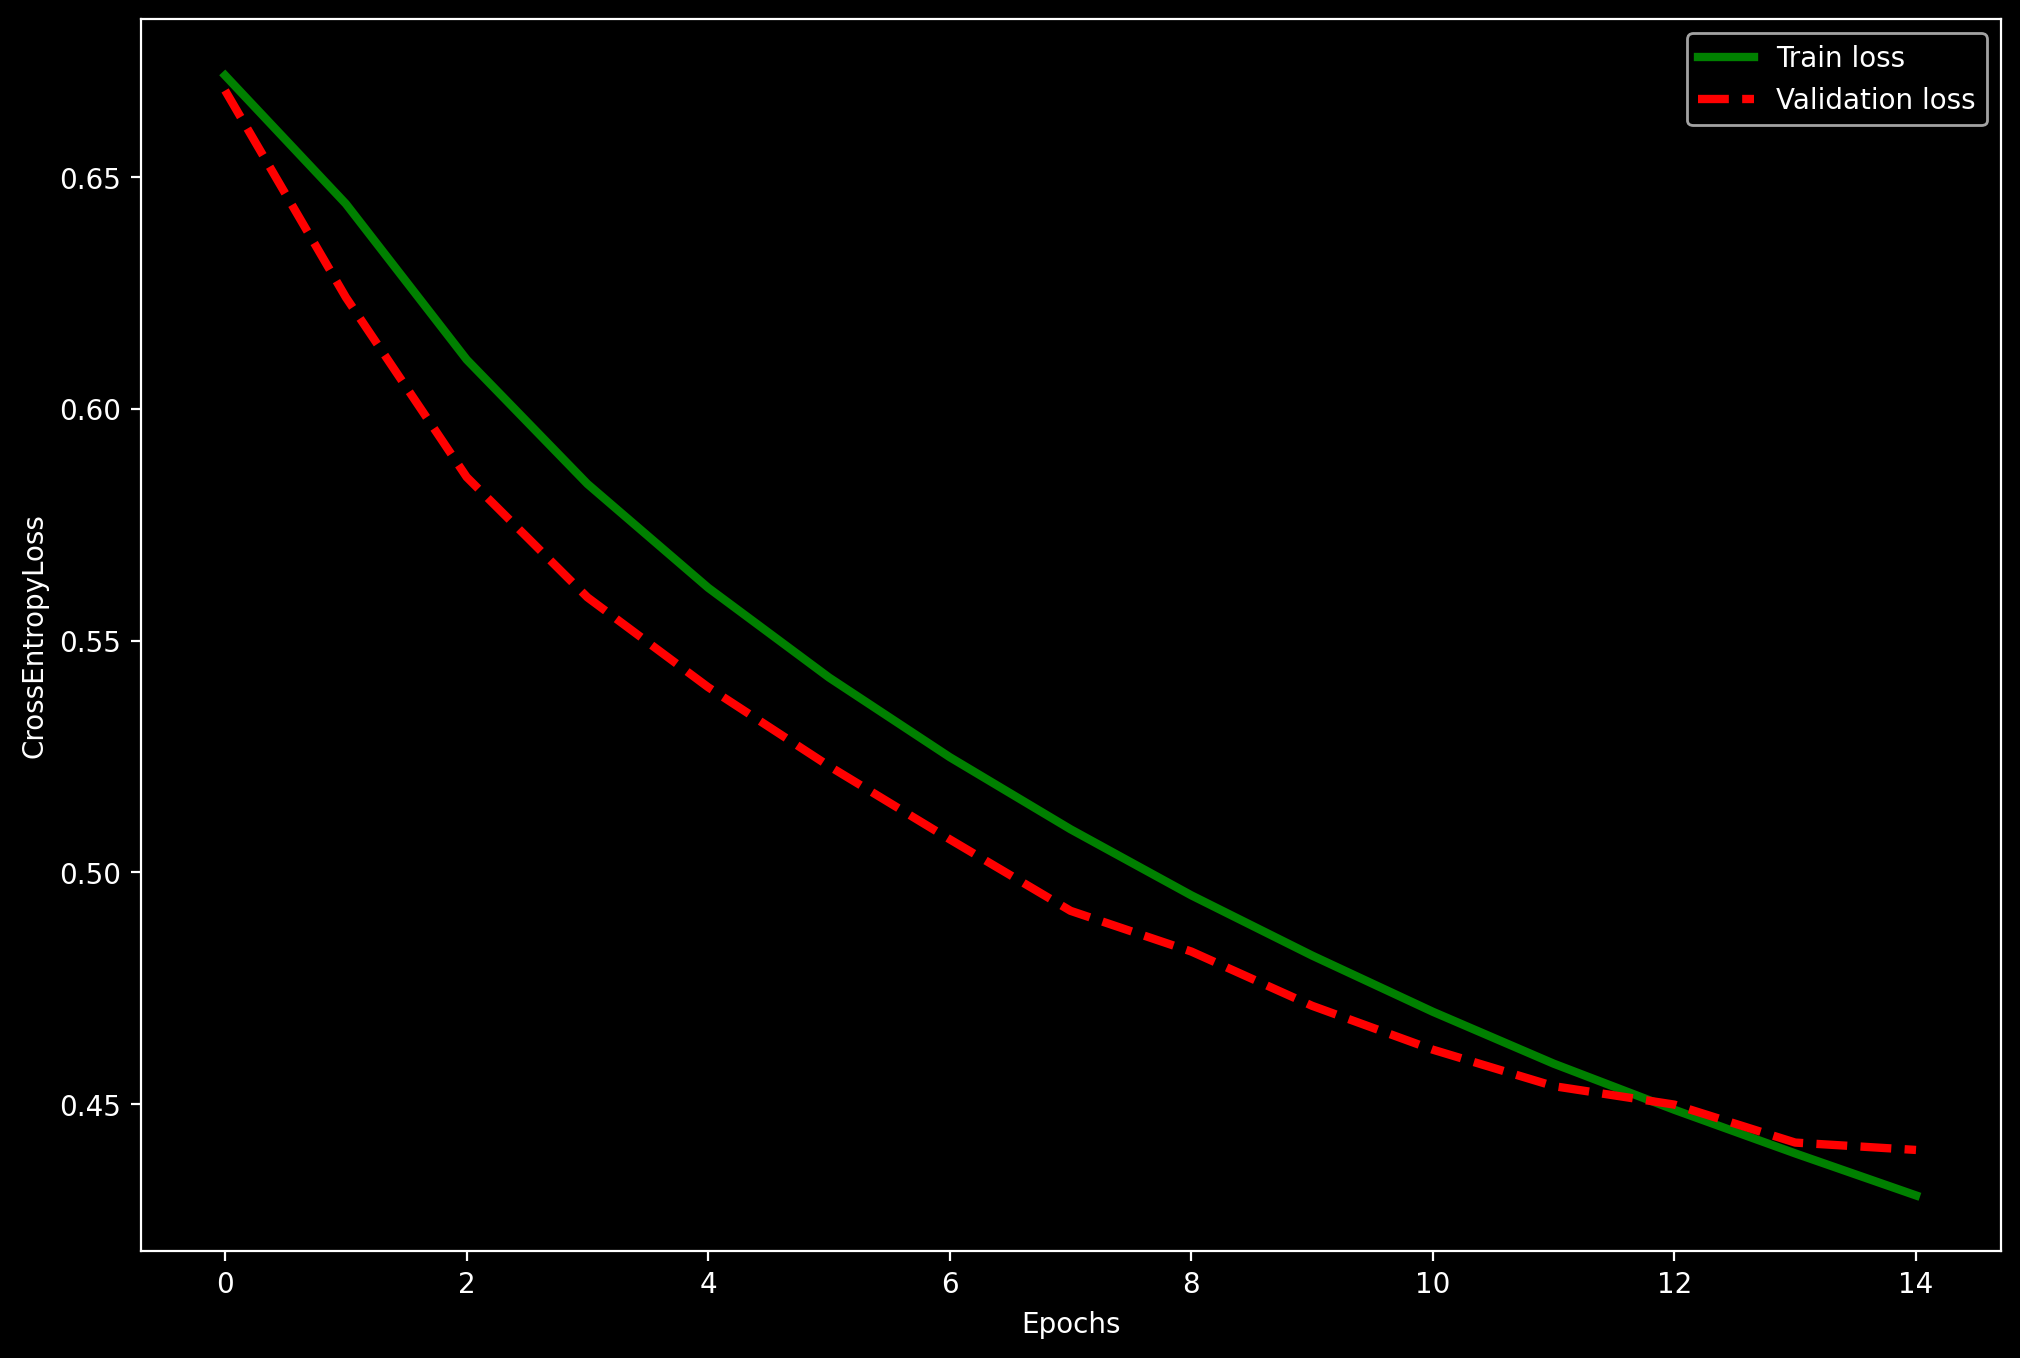

In [ ]:
plt.figure(figsize=(12, 8), dpi=200)
plt.plot(total_loss, color='green', label='Train loss', linewidth=3)
plt.plot(total_val_loss, color='red', label='Validation loss', linestyle='--', linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('CrossEntropyLoss')
plt.legend();

## Create VGG 16 Model

In [14]:
class VGG16(nn.Module):
  def __init__(self, out_nc):
    super().__init__()

    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(2, 2)
    self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))

    self.conv_1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.conv_1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

    self.conv_2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv_2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)


    self.conv_3_1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.conv_3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.conv_3_3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

    # self.conv_4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    # self.conv_4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    # self.conv_4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

    # self.conv_5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    # self.conv_5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    # self.conv_5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

    self.fci1 = nn.Flatten()
    self.fc1 = nn.Linear(128, 128)
    # self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(128, out_nc)


  def forward(self, x):
    x = self.conv_1_1(x)
    x = self.relu(x)
    x = self.conv_1_2(x)
    x = self.relu(x)

    x = self.maxpool(x)


    x = self.conv_2_1(x)
    x = self.relu(x)
    x = self.conv_2_2(x)
    x = self.relu(x)

    x = self.maxpool(x)

    x = self.conv_3_1(x)
    x = self.relu(x)
    x = self.conv_3_2(x)
    x = self.relu(x)
    x = self.conv_3_3(x)
    x = self.relu(x)

    x = self.maxpool(x)

    x = self.adaptivepool(x)

    # x = self.conv_4_1(x)
    # x = self.relu(x)
    # x = self.conv_4_2(x)
    # x = self.relu(x)
    # x = self.conv_4_3(x)
    # x = self.relu(x)

    # x = self.maxpool(x)

    # x = self.conv_5_1(x)
    # x = self.relu(x)
    # x = self.conv_5_2(x)
    # x = self.relu(x)
    # x = self.conv_5_3(x)
    # x = self.relu(x)

    # x = self.maxpool(x)

    x = self.fci1(x)
    x = self.fc1(x)
    x = self.relu(x)
    # x = self.fc2(x)
    # x = self.relu(x)
    x = self.fc3(x)

    return x

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

vgg16_model = VGG16(2).to(DEVICE)
loss_function = nn.BCEWithLogitsLoss().to(DEVICE)
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=0.0001)
EPOCHS = 7

In [ ]:
train_loss = []
total_loss = []

val_loss = []
total_val_loss = []

acc_train = []
acc_val = []

size = len(train_dataset)

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    print(f'Epochs {epoch+1} \n------------------------')
    for iteration, tensor in enumerate(train_loader):

      X_batch = tensor.get('img').to(DEVICE)
      y_batch = tensor.get('label').to(DEVICE)
      y_batch = F.one_hot(y_batch, 2).to(torch.float32)

      vgg16_model.train()
      optimizer.zero_grad()

      outputs = vgg16_model(X_batch)
      loss = loss_function(outputs, y_batch)

      loss.backward()

      acc = accuracy(outputs, y_batch)

      acc_train.append(acc)
      train_loss.append(loss.detach().cpu().numpy().item())

      optimizer.step()

      current = (iteration + 1) * len(X_batch)
      if current % 1000 == 0:
          print(f'loss: {loss:>7f} [{current}|{size:>2d}] Accuracy: {np.mean(acc_train)}')

    total_loss.append(np.mean(train_loss)) # для графика

    for iteration, tensor in enumerate(test_loader):
      X_val = tensor.get('img').to(DEVICE)
      y_val = tensor.get('label').to(DEVICE)
      y_val = F.one_hot(y_val, 2).to(torch.float32)
      with torch.no_grad():
          vgg16_model.eval()

          outputs = vgg16_model(X_val)

          loss = loss_function(outputs, y_val)
          acc = accuracy(outputs, y_val)

          acc_val.append(acc)
          val_loss.append(loss.detach().cpu().numpy().item())

    total_val_loss.append(np.mean(val_loss)) # для графика
    print(f'Validation Error:\nAccuracy: {np.mean(acc_val)} Avg Loss: {np.mean(val_loss)}')

  0%|          | 0/7 [00:00<?, ?it/s]

Epochs 1 
------------------------


<ipython-input-16-181d0426d01e>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).cpu().numpy().argmax(1) == target.cpu().numpy().argmax(1)


loss: 0.689391 [1000|23000] Accuracy: 0.499
loss: 0.689537 [2000|23000] Accuracy: 0.5035
loss: 0.681067 [3000|23000] Accuracy: 0.51
loss: 0.654158 [4000|23000] Accuracy: 0.51775
loss: 0.684599 [5000|23000] Accuracy: 0.5178
loss: 0.621968 [6000|23000] Accuracy: 0.5225
loss: 0.757821 [7000|23000] Accuracy: 0.5277142857142857
loss: 0.615391 [8000|23000] Accuracy: 0.532875
loss: 0.575198 [9000|23000] Accuracy: 0.5375555555555556
loss: 0.639213 [10000|23000] Accuracy: 0.5392
loss: 0.595452 [11000|23000] Accuracy: 0.5432727272727272
loss: 0.690146 [12000|23000] Accuracy: 0.5431666666666667
loss: 0.692633 [13000|23000] Accuracy: 0.5436923076923077
loss: 0.635918 [14000|23000] Accuracy: 0.5452857142857143
loss: 0.702889 [15000|23000] Accuracy: 0.5466
loss: 0.751476 [16000|23000] Accuracy: 0.5471875
loss: 0.587550 [17000|23000] Accuracy: 0.5495882352941176
loss: 0.625442 [18000|23000] Accuracy: 0.5498888888888889
loss: 0.607902 [19000|23000] Accuracy: 0.5517894736842105
loss: 0.747026 [20000|23

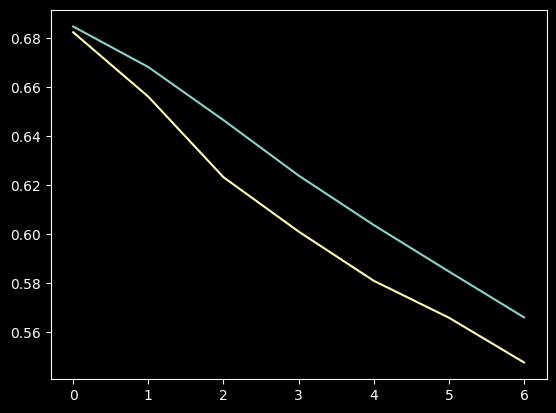

In [ ]:
plt.plot(total_loss)
plt.plot(total_val_loss)

## Save model

In [ ]:
checkpoints = {'model': VGG16(2),
               'state_dict': vgg16_model.state_dict(),
               'optimizer': optimizer.state_dict()}

In [ ]:
torch.save(checkpoints, 'dogscats_acc_70.pth')

## Predict

In [17]:
def upload_img(img_path:str) -> np.array:
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [27]:
def edit_img(img: np.array, width_img:int, height_img:int) -> torch.Tensor:
    img = img.astype(np.float32)
    img = img / 255.0
    img = cv2.resize(img, (width_img, height_img), cv2.INTER_AREA)
    plt.imshow(img)

    img = img.transpose((2,  0, 1))
    img = np.expand_dims(img, 0)
    t_img = torch.from_numpy(img)
    return t_img

In [19]:
def predict(model, img: torch.Tensor) -> int:
    with torch.no_grad():
        model.eval()
        pred = model(img)

        sigmoid = torch.sigmoid(pred)[0]

        print(f'Вероятность, что это кошка составляет: {sigmoid[1]}\nВероятность, что это собака составляет: {sigmoid[0]}')

        pred = torch.argmax(pred, 1)
    return pred.detach().cpu().numpy().item()

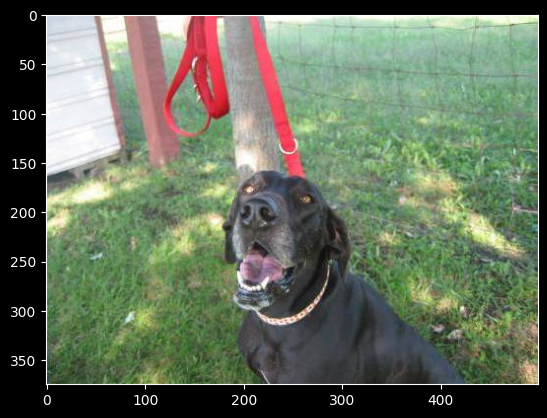

In [85]:
img = upload_img('/content/dogscats/dogscats/test1/10838.jpg')
plt.imshow(img)

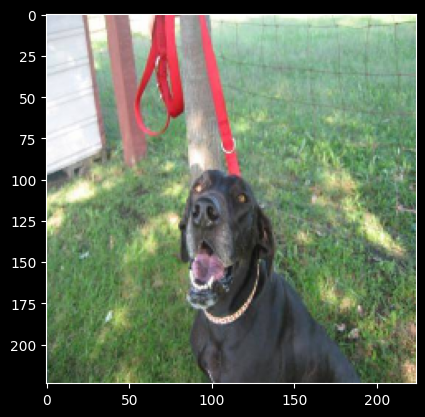

In [86]:
img = edit_img(img, 224, 224)

In [87]:
img.shape

torch.Size([1, 3, 224, 224])

In [88]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(DEVICE)
img = img.to(DEVICE)

In [89]:
if predict(model, img):
    print('Кошка')
else:
    print('Собака')

Вероятность, что это кошка составляет: 0.006598311476409435
Вероятность, что это собака составляет: 0.9934816360473633
Собака


## Load the Model

In [15]:
def load_checkpoint(filepath: str):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()

    return model

In [16]:
model = load_checkpoint('/content/dogscats_acc_70.pth')
print(model)

VGG16(
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fci1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
